In [3]:
!pip install wordcloud matplotlib

In [4]:
import pandas as pd
article_df = pd.read_csv('/Users/amalkurian/Desktop/Dissertation/Bias Detection/Deliverables/matching_articles04.csv')

In [5]:
article_df.columns

Index(['doc_id', 'doc_id.1', 'doc_id.2', 'doc_id.3', 'doc_id.4', 'title',
       'author', 'source', 'content', 'topic', 'url', 'keywords', 'query',
       'cleaned_content', 'entities', 'article_id', 'entities_Group',
       'labels_Group', 'Key_Phrases', 'Actions', 'Load_Date', 'Language',
       'Person', 'matching_events', 'character_count', 'word_count',
       'processed_text', 'processed_tokens_split', 'num_tokens', 'story_chain',
       'match_score_faiss', 'temporal_scores', 'temporal_exp_score',
       'temporal_log_score', 'match_score_Title', 'event_similarity_id_Title',
       'match_label_x', 'match_label_y', 'match_label', 'actor_entities',
       'geo_entities', 'entity_similarity', 'final_scores', 'max_score_index',
       'match_Labels', 'Top_event_id', 'Top_event_title'],
      dtype='object')

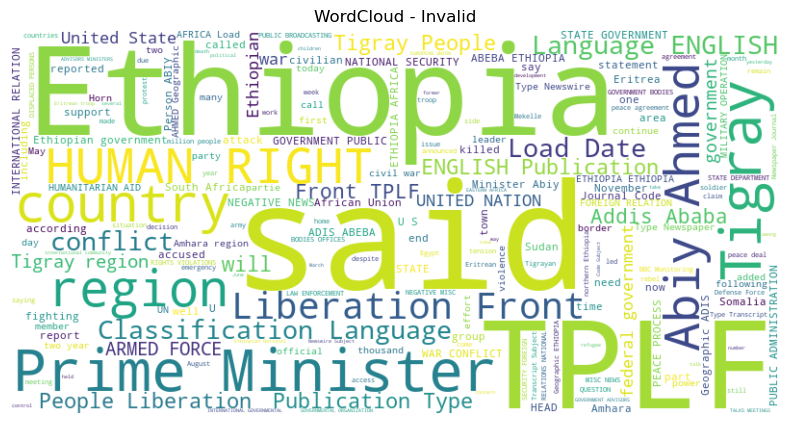

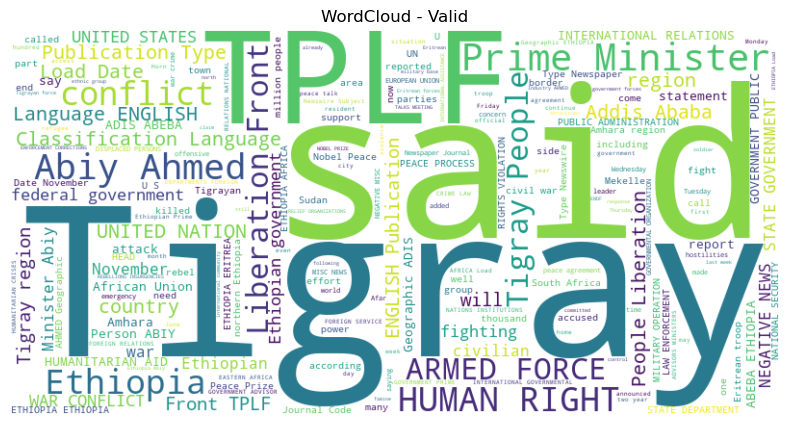

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

def plot_wordclouds(df, group_col="bias", text_col="text"):
    groups = df.groupby(group_col)[text_col].apply(lambda x: " ".join(x))
    for bias, text in groups.items():
        wc = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"WordCloud - {bias}")
        plt.show()


plot_wordclouds(article_df, group_col=[ 'match_Labels'], text_col="cleaned_content")        


In [7]:
print(article_df.columns)


Index(['doc_id', 'doc_id.1', 'doc_id.2', 'doc_id.3', 'doc_id.4', 'title',
       'author', 'source', 'content', 'topic', 'url', 'keywords', 'query',
       'cleaned_content', 'entities', 'article_id', 'entities_Group',
       'labels_Group', 'Key_Phrases', 'Actions', 'Load_Date', 'Language',
       'Person', 'matching_events', 'character_count', 'word_count',
       'processed_text', 'processed_tokens_split', 'num_tokens', 'story_chain',
       'match_score_faiss', 'temporal_scores', 'temporal_exp_score',
       'temporal_log_score', 'match_score_Title', 'event_similarity_id_Title',
       'match_label_x', 'match_label_y', 'match_label', 'actor_entities',
       'geo_entities', 'entity_similarity', 'final_scores', 'max_score_index',
       'match_Labels', 'Top_event_id', 'Top_event_title'],
      dtype='object')


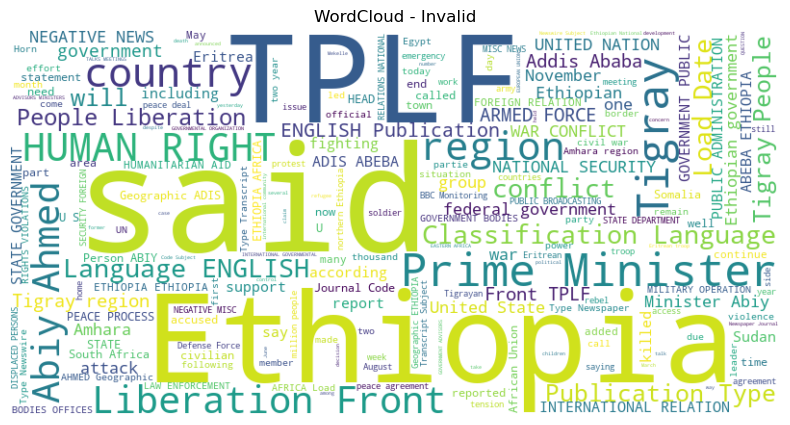

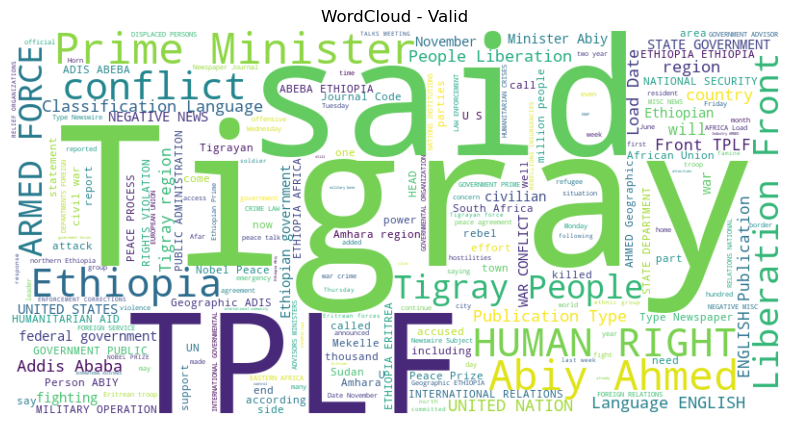

In [8]:


def plot_wordclouds(df, group_col="bias", text_col="text"):
    groups = df.groupby(group_col)[text_col].apply(lambda x: " ".join(x))
    for bias, text in groups.items():
        wc = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"WordCloud - {bias}")
        plt.show()


plot_wordclouds(article_df, group_col='match_Labels', text_col="cleaned_content")        


In [9]:
article_df.columns

Index(['doc_id', 'doc_id.1', 'doc_id.2', 'doc_id.3', 'doc_id.4', 'title',
       'author', 'source', 'content', 'topic', 'url', 'keywords', 'query',
       'cleaned_content', 'entities', 'article_id', 'entities_Group',
       'labels_Group', 'Key_Phrases', 'Actions', 'Load_Date', 'Language',
       'Person', 'matching_events', 'character_count', 'word_count',
       'processed_text', 'processed_tokens_split', 'num_tokens', 'story_chain',
       'match_score_faiss', 'temporal_scores', 'temporal_exp_score',
       'temporal_log_score', 'match_score_Title', 'event_similarity_id_Title',
       'match_label_x', 'match_label_y', 'match_label', 'actor_entities',
       'geo_entities', 'entity_similarity', 'final_scores', 'max_score_index',
       'match_Labels', 'Top_event_id', 'Top_event_title'],
      dtype='object')

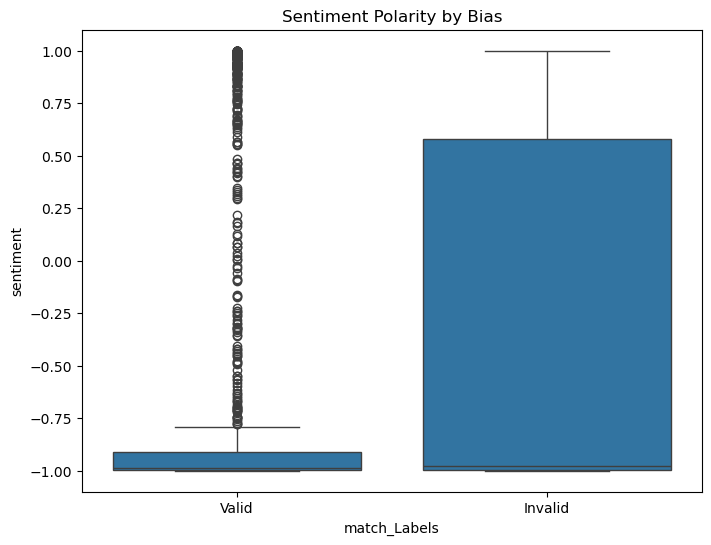

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns

sia = SentimentIntensityAnalyzer()
article_df['sentiment'] = article_df['cleaned_content'].apply(lambda x: sia.polarity_scores(x)['compound'])

plt.figure(figsize=(8,6))
sns.boxplot(x='match_Labels', y="sentiment", data=article_df)
plt.title("Sentiment Polarity by Bias")
plt.show()


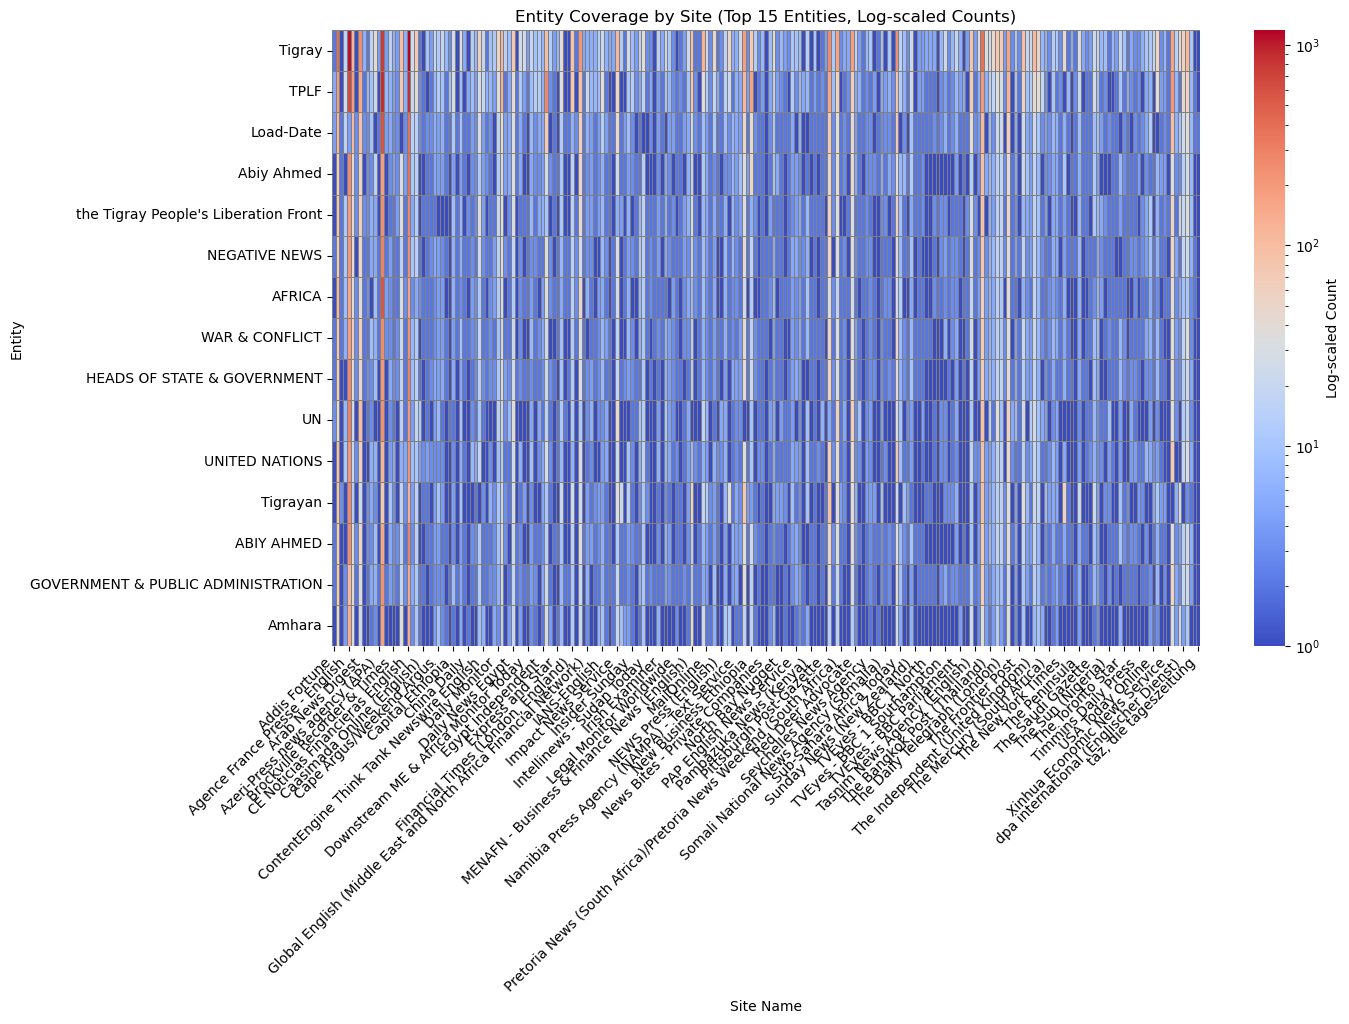

In [11]:
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# ------------------------------
# Load English NLP model
# ------------------------------
nlp = spacy.load("en_core_web_sm")

# ------------------------------
# Extract PERSON and ORG entities from cleaned content
# ------------------------------
entity_counts = []
for _, row in article_df.iterrows():
    doc = nlp(row['cleaned_content'])
    ents = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG"]]
    for ent in ents:
        entity_counts.append({"entity": ent, "site": row["source"]})

ents_df = pd.DataFrame(entity_counts)

# ------------------------------
# Aggregate counts by entity and site
# ------------------------------
coverage = ents_df.groupby(["entity", "site"]).size().reset_index(name="count")

# ------------------------------
# Pivot for heatmap
# ------------------------------
coverage_pivot = coverage.pivot(index="entity", columns="site", values="count").fillna(0)

# ------------------------------
# Filter top N entities to reduce congestion
# ------------------------------
top_entities = coverage_pivot.sum(axis=1).sort_values(ascending=False).head(15).index
coverage_pivot = coverage_pivot.loc[top_entities]

# ------------------------------
# Plot heatmap using log-scaled counts
# ------------------------------
plt.figure(figsize=(14, 8))
sns.heatmap(
    coverage_pivot + 1,  # add 1 to avoid log(0)
    cmap="coolwarm",
    norm=LogNorm(),
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Log-scaled Count'}
)
plt.title("Entity Coverage by Site (Top 15 Entities, Log-scaled Counts)")
plt.ylabel("Entity")
plt.xlabel("Site Name")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


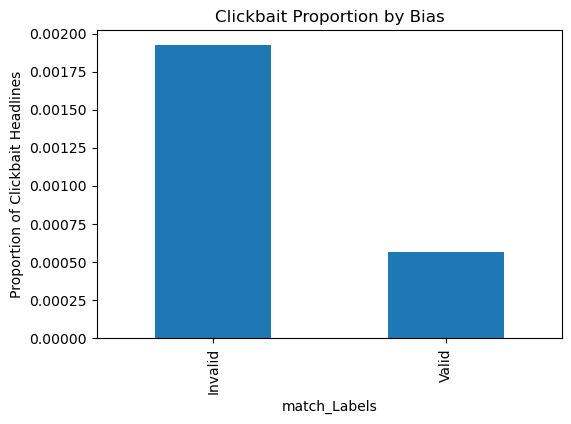

In [12]:
import re

def is_clickbait(text):
    patterns = [
        r"(won't believe|shocking|must see|breaking|epic)",
        r"^\d+\s+(things|reasons|facts)",
        r"(you(’|')ll never guess|what happened next| the truth about)",
        r"(\?{2,}|!{2,}|\.{3,})",
        r"\b[A-Z]{4,}\b"
    ]
    return any(re.search(p, text.lower()) for p in patterns)


article_df['clickbait'] = article_df['title'].apply(is_clickbait)
clickbait_stats = article_df.groupby('match_Labels')['clickbait'].mean()

clickbait_stats.plot(kind="bar", figsize=(6,4))
plt.title("Clickbait Proportion by Bias")
plt.ylabel("Proportion of Clickbait Headlines")
plt.show()


count    3322.000000
mean        0.001204
std         0.034684
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: clickbait_score, dtype: float64
clickbait_score
0    3318
1       4
Name: count, dtype: int64


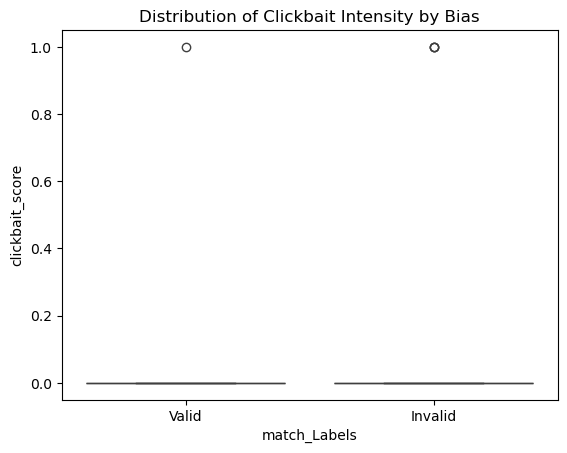

In [13]:
def clickbait_score(text):
    patterns = [
        r"(won't believe|shocking|must see|breaking|epic)",
        r"^\d+\s+(things|reasons|facts)",
        r"(you(’|')ll never guess|what happened next|the truth about)",
        r"(\?{2,}|!{2,}|\.{3,})",
        r"\b[A-Z]{4,}\b"
    ]
    return sum(bool(re.search(p, text.lower())) for p in patterns)

article_df['clickbait_score'] = article_df['title'].apply(clickbait_score)
print(article_df['clickbait_score'].describe())
print(article_df['clickbait_score'].value_counts())


sns.boxplot(data=article_df, x="match_Labels", y="clickbait_score")
plt.title("Distribution of Clickbait Intensity by Bias")
plt.show()


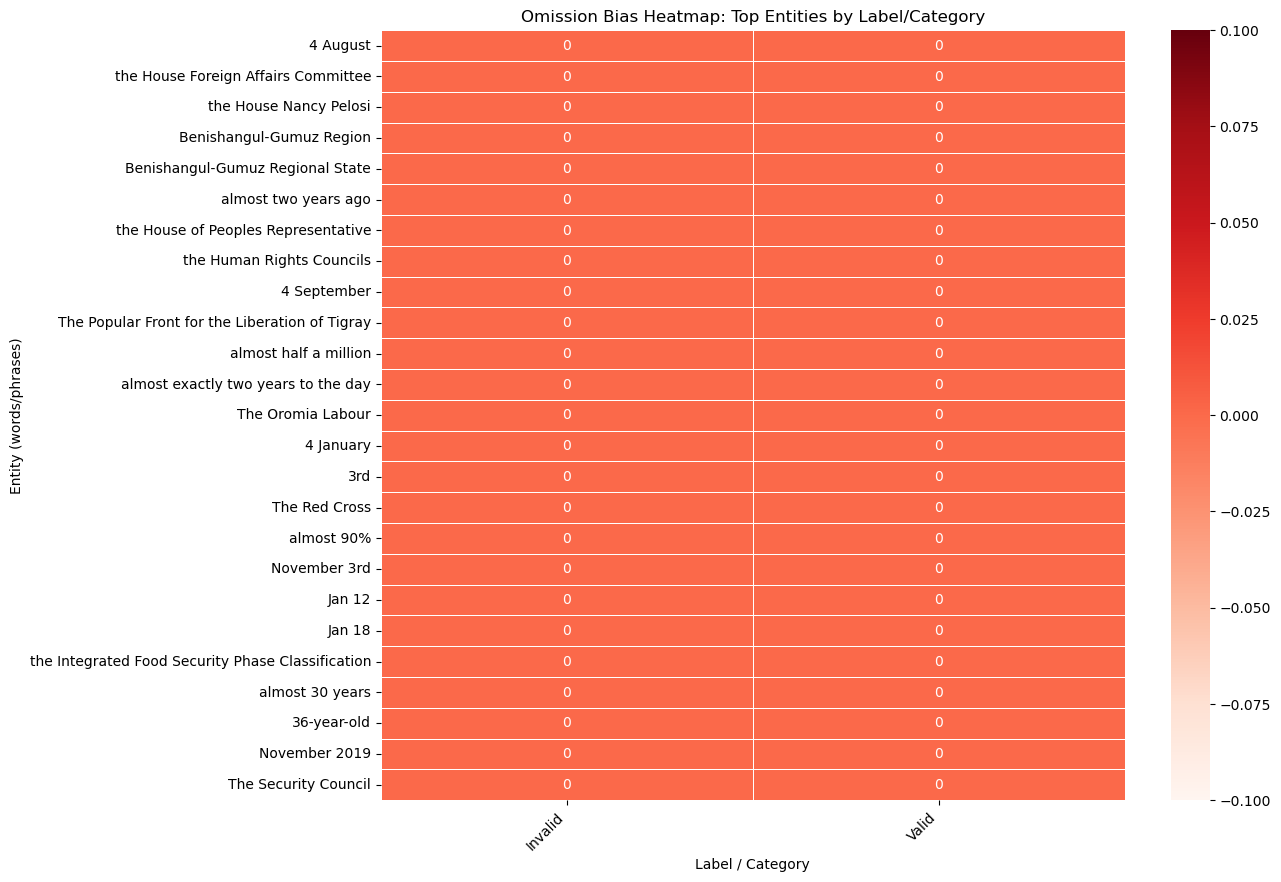

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ------------------------------
# 1️⃣ Clean entity helper
# ------------------------------
def clean_entity(e):
    if not isinstance(e, str):
        return None
    e = e.strip().replace("'", "").replace('"', '')  
    e = re.sub(r'&#\d+;', '', e)
    if re.match(r'^[\d\.\-/%]+$', e):
        return None
    if len(e) < 2:
        return None
    garbage = ['Load-Date', 'today', 'yesterday', 'tomorrow']
    if e in garbage:
        return None
    return e

# ------------------------------
# 2️⃣ Clean & explode
# ------------------------------
article_df['entities_Group'] = article_df['entities_Group'].apply(
    lambda x: x.split(',') if isinstance(x, str) else (x if isinstance(x, list) else [])
)
article_df['entities_Group'] = article_df['entities_Group'].apply(
    lambda lst: [clean_entity(e) for e in lst if clean_entity(e)]
)

all_entities = article_df.explode('entities_Group')

# ------------------------------
# 3️⃣ Count mentions
# ------------------------------
counts_df = all_entities.groupby(['entities_Group', 'match_Labels']).size().reset_index(name='count')
heatmap_df = counts_df.pivot(index='entities_Group', columns='match_Labels', values='count').fillna(0)

# ------------------------------
# 4️⃣ Compute expected counts per entity (broadcast across columns)
# ------------------------------
expected_per_label = pd.DataFrame(
    (heatmap_df.sum(axis=1) / heatmap_df.shape[1]).values[:, None].repeat(heatmap_df.shape[1], axis=1),
    index=heatmap_df.index,
    columns=heatmap_df.columns
)

# Compute omission (clip negative)
omission_df = expected_per_label - heatmap_df
omission_df[omission_df < 0] = 0

# ------------------------------
# 5️⃣ Top 25 omitted entities
# ------------------------------
top_entities = omission_df.sum(axis=1).sort_values(ascending=True).head(25).index
omission_top = omission_df.loc[top_entities]

# ------------------------------
# 6️⃣ Plot heatmap
# ------------------------------
plt.figure(figsize=(12,10))
sns.heatmap(omission_top, cmap='Reds', linewidths=0.5, annot=True)
plt.title("Omission Bias Heatmap: Top Entities by Label/Category")
plt.xlabel("Label / Category")
plt.ylabel("Entity (words/phrases)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


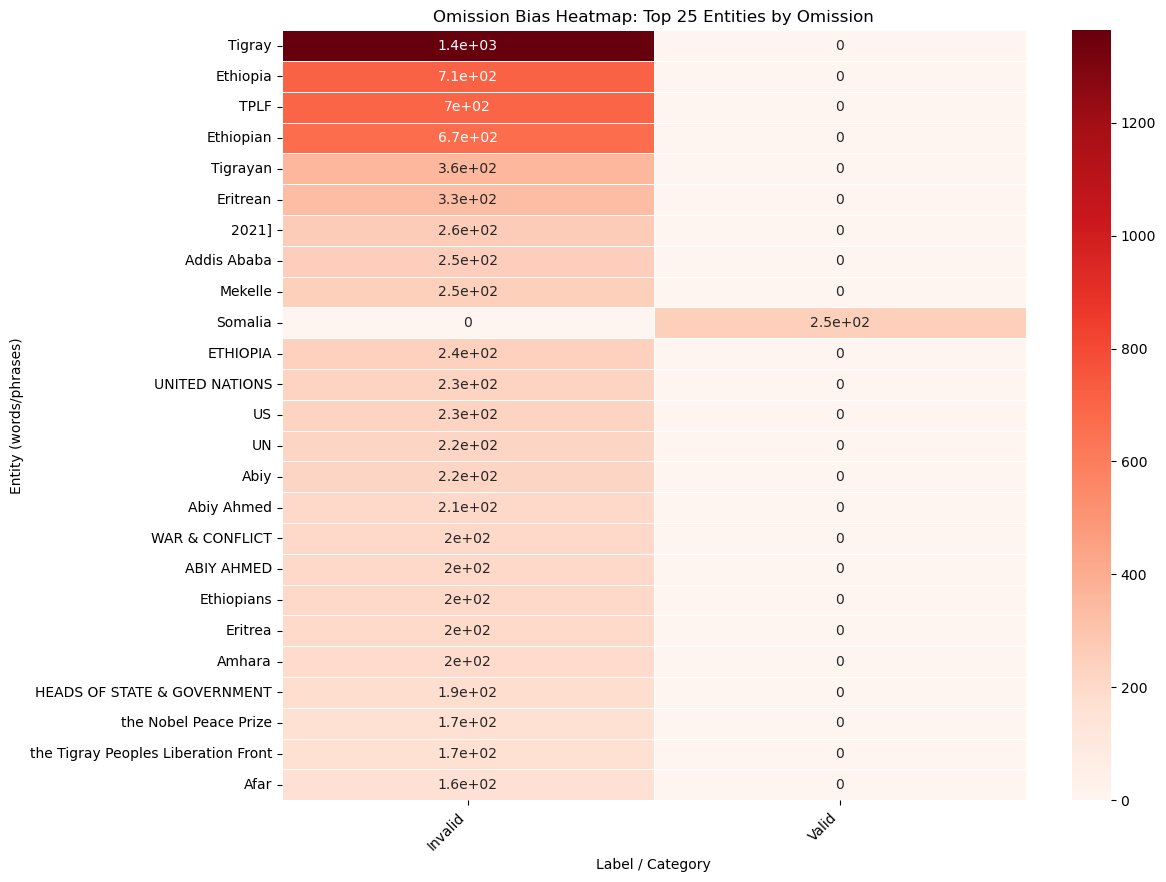

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ------------------------------
# 1️⃣ Clean entity helper
# ------------------------------
def clean_entity(e):
    if not isinstance(e, str):
        return None
    e = e.strip().replace("'", "").replace('"', '')  
    e = re.sub(r'&#\d+;', '', e)
    if re.match(r'^[\d\.\-/%]+$', e):
        return None
    if len(e) < 2:
        return None
    garbage = ['Load-Date', 'today', 'yesterday', 'tomorrow']
    if e in garbage:
        return None
    return e

# ------------------------------
# 2️⃣ Clean & explode
# ------------------------------
article_df['entities_Group'] = article_df['entities_Group'].apply(
    lambda x: x.split(',') if isinstance(x, str) else (x if isinstance(x, list) else [])
)
article_df['entities_Group'] = article_df['entities_Group'].apply(
    lambda lst: [clean_entity(e) for e in lst if clean_entity(e)]
)

all_entities = article_df.explode('entities_Group')

# ------------------------------
# 3️⃣ Count mentions
# ------------------------------
counts_df = all_entities.groupby(['entities_Group', 'match_Labels']).size().reset_index(name='count')
heatmap_df = counts_df.pivot(index='entities_Group', columns='match_Labels', values='count').fillna(0)

# ------------------------------
# 4️⃣ Compute expected counts per entity (per-entity distribution)
# ------------------------------
# Expected proportion per label for each entity
expected_per_label = heatmap_df.sum(axis=1) / heatmap_df.shape[1]
expected_df = pd.DataFrame(
    expected_per_label.values[:, None].repeat(heatmap_df.shape[1], axis=1),
    index=heatmap_df.index,
    columns=heatmap_df.columns
)

# Compute omission (difference from expected)
omission_df = expected_df - heatmap_df
omission_df[omission_df < 0] = 0  # clip negatives

# ------------------------------
# 5️⃣ Select top 25 omitted entities
# ------------------------------
# sum across labels to get total omission per entity
top_entities = omission_df.sum(axis=1).sort_values(ascending=False).head(25).index
omission_top = omission_df.loc[top_entities]

# ------------------------------
# 6️⃣ Plot heatmap
# ------------------------------
plt.figure(figsize=(12,10))
sns.heatmap(omission_top, cmap='Reds', linewidths=0.5, annot=True)
plt.title("Omission Bias Heatmap: Top 25 Entities by Omission")
plt.xlabel("Label / Category")
plt.ylabel("Entity (words/phrases)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


In [18]:
article_df['match_Labels'].value_counts()

match_Labels
Valid      1764
Invalid    1558
Name: count, dtype: int64

In [19]:
print(all_entities['entities_Group'].unique()[:50])


['[October' 'Ethiopian' 'Abiy Ahmed' 'Tigrayan' 'Amhara' 'Afar' 'yearlong'
 'thousands' 'more than 1.7 million' 'Addis Ababa' 'this week' 'Abiy'
 'Tigray' 'Richard Hartshorne' 'Ethiopia' 'Twitter'
 'the Tigrayan Peoples Liberation Front' 'China' 'Egypt' 'Eritrea'
 'Somalia' 'Sudan' 'Turkey' 'the United Arab Emirates' 'the United States'
 'East Africas' 'al Shabab' 'November 2020' 'months' 'TPLF'
 'Prosperity Party' 'Mekelle' 'Marxist' 'Derg'
 'the Ethiopian Peoples Revolutionary Democratic Front' 'EPRDF'
 'almost three decades' 'Tigrayans' 'June' 'Dessie' 'Kombolcha'
 'the Oromo Liberation Army' 'OLA'
 'the United Front of Ethiopian Federalist Forces' 'four' 'first' 'Oromo'
 'two' 'second' 'Oromia']


In [8]:
import pandas as pd
df = pd.read_csv('/Users/amalkurian/Desktop/Dissertation/Bias Detection/nexis_articles1.csv')

In [9]:
df.columns

Index(['title', 'author', 'source', 'content', 'topic', 'url', 'bias',
       'bias_labels', 'date', 'keywords', 'query'],
      dtype='object')

In [10]:
df.head(3)

,title,author,source,content,topic,url,bias,bias_labels,date,keywords,query
0,can ethiopia survive? what might happen if abi...,NaN,MENAFN - Business & Finance News (English),Can Ethiopia Survive? What Might Happen If Abi...,NaN,https://advance.lexis.com/document/teaserdocum...,NaN,NaN,05 Nov 2021,"(""state media"" OR ""cyber censorship"" OR ""socia...",NaN
1,ethiopia : eritrea confirms its troops are fig...,NaN,Thai News Service,Ethiopia: Eritrea Confirms Its Troops Are Figh...,NaN,https://advance.lexis.com/document/teaserdocum...,NaN,NaN,19 Apr 2021,"(""state media"" OR ""cyber censorship"" OR ""socia...",NaN
2,tigray crisis - ethiopia 's tigray war spills ...,RFI,RFI (English),Tigray crisis - Ethiopia's Tigray war spills i...,NaN,https://advance.lexis.com/document/teaserdocum...,NaN,NaN,18 Jul 2021,"(""state media"" OR ""cyber censorship"" OR ""socia...",NaN
